# Generative Adversarial Network (GAN)

Пришло время поговорить о более интересных архитектурах, а именно о GANах или состязательных нейронных сетках. 

Впервые GANы были предложены в 2014 году. Сейчас они очень активно исследуются. GANы состоят из двух нейронных сетей: 

* Первая - генератор порождает из некоторого заданного распределения случайные числа и собирает из них объекты, которые идут на вход второй сети. 
* Вторая - дискриминатор получает на вход объекты из реальной выборки и объекты, созданные генератором. Она пытается определить какой объект был порождён генератором, а какой является реальным.

Таким образом генератор пытается создавать объекты, которые дискриминатор не сможет отличить от реальных. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

s = keras.backend.get_session()

/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = keras.datasets.mnist.load_data()
data = data[0][0]
data = data.reshape(60000,28,28,1)
data.shape

(60000, 28, 28, 1)

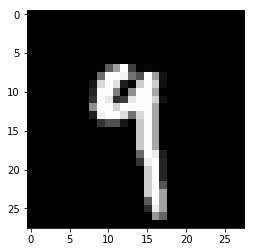

In [3]:
plt.imshow(data[np.random.randint(data.shape[0])].reshape(28,28), cmap="gray", interpolation="none")

## Дискриминатор 

* Дискриминатор - это обычная свёрточная сетка 
* Цель этой сетки - отличать сгенерированные изображения от реальных

In [6]:
IMG_SHAPE = data.shape[1:] # размер картинки 

In [7]:
discriminator = Sequential()

discriminator.add(L.Conv2D(32, kernel_size=(5,5), padding='same', activation = 'relu', input_shape=IMG_SHAPE))
discriminator.add(L.MaxPooling2D((2,2),padding='same'))
discriminator.add(L.Conv2D(16,kernel_size=(2,2), activation = 'relu',padding='same'))
discriminator.add(L.MaxPooling2D((2,2),padding='same'))
discriminator.add(L.Conv2D(1, kernel_size=(5,5), activation = 'relu', padding='same'))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='sigmoid')) # попробовать тангенс 
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

## Генератор

* Генерирует из шума изображения 


Будем генерировать новые цифры из шума размера 256.

In [8]:
CODE_SIZE = 256

In [9]:
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*4*4, activation='elu'))

generator.add(L.Reshape((4,4,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(1, kernel_size=3, activation=None))

print('Выход генератора: ', generator.output_shape[1:])

Выход генератора:  (28, 28, 1)


## Обучение 

Сетки обучаются поэтапно в рамках одной сети. 

* Делаем $k$ шагов обучения дискриминатора. Целевая переменная - реальный объект перед нами или порождённый. Веса изменяем стандартно, пытаясь уменьшить кросс-энтропию.
* Делаем шаг обучения генератора. Веса внутри сетки меняем так, чтобы увеличить логарифм вероятности дискриминатора присвоить сгенерированному объекту лэйбл реального. 
* Обучаем итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (либо пока у нас не закончится терпение).
* При обучении может возникнуть огромное количество пробем от взрыва весов до более тонких вещей. Имеет смысл посмотреть на разные трюки, используемые при обучении:  https://github.com/soumith/ganhacks

Собираем структуру для обучения. Для этого мы будем использовать средства TensorFlow. Объявив модели, мы можем применять их напрямую к плэйсхолдерам.

Заведём плейсхолдер для шума и для реальных данных, применим к ним наши преобразования.

In [10]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data) 
generated_data = generator(noise)
logp_gen =  discriminator(generator(noise))  # <log P(real | gen(noise))

Теперь определим потери для реального изображения и для сгенерированного. 

In [11]:
# ошибка для дискриминатора
d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

# немного регуляризации, чтобы не запомнить базовую выборку
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

# оптимизатор
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [12]:
# ошибка для генератора 
g_loss = tf.reduce_mean(logp_gen[:,0])

# оптимизатор
gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

In [13]:
# инициализация глобальных переменных
s.run(tf.global_variables_initializer())

Несколько вспомогательных функций для рисования текущих распределённых данных.

In [14]:
IMG_SHAPE

(28, 28, 1)

In [15]:
# функция, которая генерирует батч с шумом
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

# функция, которая генерирует батч из реальных данных
def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

# рисуем изображения
def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE[:-1]),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE[:-1]),cmap="gray")
    plt.show()

# рисуем распределения
def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

Приступим к тренировке сеток. 

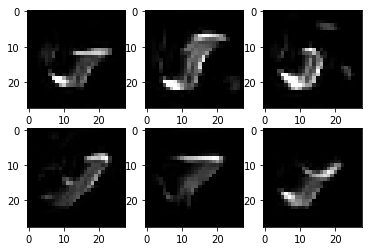

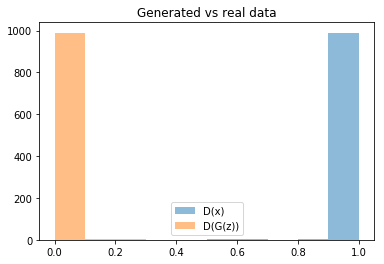

In [16]:
from IPython import display
from tqdm import tnrange

# вектора для мониторинга сходимости сеток
d_losses = [ ]
g_losses = [ ]

for epoch in tnrange(5000):
    # генерируем батчи
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    # делаем пять шагов обучения дискриминатора
    for i in range(5):
        s.run(disc_optimizer, feed_dict)
    d_losses.append(s.run(d_loss, feed_dict))
    
    # шаг обучения генератора
    s.run(gen_optimizer,feed_dict)
    g_losses.append(s.run(g_loss, feed_dict))
    
    # каждые сто шагов обновляем картинку
    if epoch %100==0:
        print('Текущая эпоха: ', epoch)
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)  

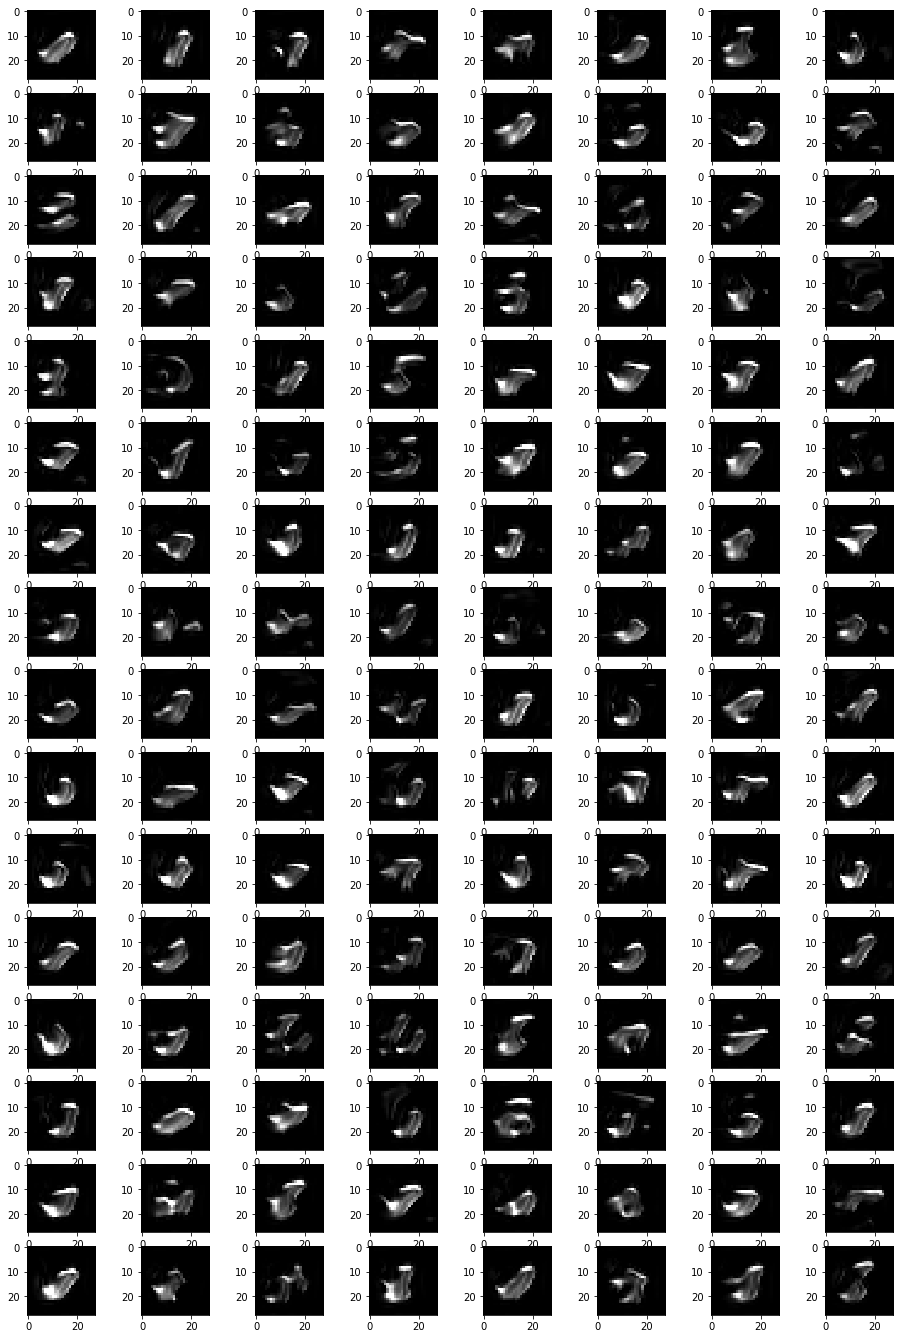

In [17]:
# сетка тренировалась 5000 итераций
plt.figure(figsize=[16,24])
sample_images(16,8)  

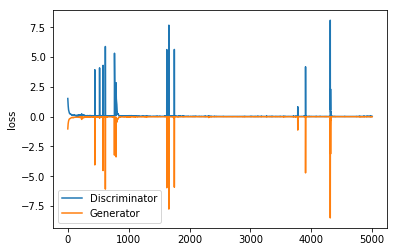

In [18]:
# вопрос на засыпку! Что произошло при обучении?
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.ylabel('loss')
plt.legend();